In [1]:
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
import numpy as np
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.regularizers import l1, l2

Using TensorFlow backend.


In [2]:
# convert series to supervised learning & normalize input variables
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def data_preparation(df):
    # Get names of indexes for which column temporarily_unable_test has value 1000
    index = df[ df['number_busy'] > 2000 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Get names of indexes for which column temporarily_unable_test has value 1000
    index = df[ df['temporarily_unable_test'] > 1000 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['followup_tests'] = np.log(df['followup_tests'] + 1)
    
    # Get names of indexes for which column outage_hrs has value > 300 
    index = df[ df['quality_too_poor'] > 300 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['outage_hrs'] = np.log(df['outage_hrs'])
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['numbers_tested'] = np.log(df['numbers_tested'])
    
    #df.drop(['followup_tests','outage_hrs', 'numbers_tested'], inplace=True, axis=1)
    
    return df

In [4]:
# load dataset
df = read_csv('../reports/company_report_2.csv', header=0, index_col="time") #2, 9, 49, 93, 130
#df = data_preparation(df)
df = df[['volume_tests', 'date', 'month', 'is_weekend', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'min_commit']]
df = df.dropna(axis='columns')
values = df.values

# specify the number of days and features 
n_input = 7
n_features = df.shape[1]
n_predict = 7

# integer encode direction
#encoder = LabelEncoder()
#values[:,3] = encoder.fit_transform(values[:,3])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_input, n_predict)
print(reframed.shape)

(1193, 154)


In [5]:
# split into train and test sets
values = reframed.values

train_size = int(len(values) * 0.80)
test_size = len(values) - train_size
train, test = values[:train_size,:], values[train_size:,:]

# split into input and outputs
n_obs = n_input * n_features
n_predict_obs = n_predict * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_predict_obs::n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_predict_obs::n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_input, n_features))
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(954, 77) 954 (954, 7)
(954, 7, 11) (954, 7) (239, 7, 11) (239, 7)


Train on 954 samples, validate on 239 samples
Epoch 1/100
954/954 - 3s - loss: 0.1919 - accuracy: 0.1226 - val_loss: 0.1984 - val_accuracy: 0.1381
Epoch 2/100
954/954 - 0s - loss: 0.1780 - accuracy: 0.1478 - val_loss: 0.1854 - val_accuracy: 0.1799
Epoch 3/100
954/954 - 0s - loss: 0.1716 - accuracy: 0.1688 - val_loss: 0.1901 - val_accuracy: 0.1715
Epoch 4/100
954/954 - 0s - loss: 0.1722 - accuracy: 0.1908 - val_loss: 0.1877 - val_accuracy: 0.1632
Epoch 5/100
954/954 - 0s - loss: 0.1641 - accuracy: 0.2358 - val_loss: 0.1883 - val_accuracy: 0.2008
Epoch 6/100
954/954 - 0s - loss: 0.1612 - accuracy: 0.2736 - val_loss: 0.1842 - val_accuracy: 0.2218
Epoch 7/100
954/954 - 0s - loss: 0.1511 - accuracy: 0.2893 - val_loss: 0.1803 - val_accuracy: 0.2343
Epoch 8/100
954/954 - 0s - loss: 0.1445 - accuracy: 0.3176 - val_loss: 0.1654 - val_accuracy: 0.2720
Epoch 9/100
954/954 - 0s - loss: 0.1301 - accuracy: 0.3071 - val_loss: 0.1544 - val_accuracy: 0.2678
Epoch 10/100
954/954 - 0s - loss: 0.1210 - ac

Epoch 81/100
954/954 - 0s - loss: 0.0377 - accuracy: 0.2904 - val_loss: 0.0584 - val_accuracy: 0.1715
Epoch 82/100
954/954 - 0s - loss: 0.0367 - accuracy: 0.3113 - val_loss: 0.0822 - val_accuracy: 0.2050
Epoch 83/100
954/954 - 0s - loss: 0.0426 - accuracy: 0.2935 - val_loss: 0.0721 - val_accuracy: 0.1674
Epoch 84/100
954/954 - 0s - loss: 0.0464 - accuracy: 0.2642 - val_loss: 0.0587 - val_accuracy: 0.1381
Epoch 85/100
954/954 - 0s - loss: 0.0420 - accuracy: 0.2704 - val_loss: 0.0835 - val_accuracy: 0.1841
Epoch 86/100
954/954 - 0s - loss: 0.0408 - accuracy: 0.2945 - val_loss: 0.0763 - val_accuracy: 0.2008
Epoch 87/100
954/954 - 0s - loss: 0.0484 - accuracy: 0.2610 - val_loss: 0.0616 - val_accuracy: 0.1925
Epoch 88/100
954/954 - 0s - loss: 0.0399 - accuracy: 0.2778 - val_loss: 0.0990 - val_accuracy: 0.2343
Epoch 89/100
954/954 - 0s - loss: 0.0429 - accuracy: 0.2746 - val_loss: 0.0657 - val_accuracy: 0.1841
Epoch 90/100
954/954 - 0s - loss: 0.0350 - accuracy: 0.2914 - val_loss: 0.0764 - v

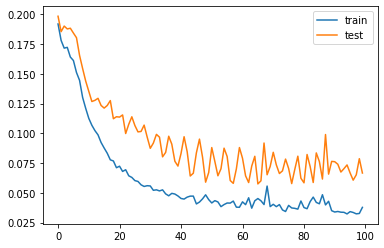

In [6]:
# design LSTM Model
model = Sequential()

model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape=(train_X.shape[1], train_X.shape[2]) ))
model.add(Dropout(0.1))
#model.add(BatchNormalization())

model.add(Dense(n_predict, kernel_initializer='lecun_uniform', activation='hard_sigmoid'))

optimizer = Adam(lr=0.001, decay=1e-6)
model.compile(loss='mae', optimizer=optimizer, metrics=['accuracy'])

# fit Model
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot loss history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [7]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_input*n_features))

print(yhat.shape)
print(test_X[:, -(n_features-1):].shape)

pred_arr = np.empty((test_X.shape[0], 1))
actual_arr = np.empty((test_X.shape[0], 1))

for i in range(0, yhat.shape[1]):
    # invert scaling for forecast
    yhat_col = yhat[:, i].reshape(len(yhat[:, i]), 1)    
    inv_yhat = concatenate((yhat_col, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    inv_yhat = inv_yhat.reshape(len(inv_yhat), 1)
    pred_arr = np.append(pred_arr, inv_yhat, axis=1)    
pred_arr = pred_arr[:,1:]

for i in range(0, test_y.shape[1]):
    # invert scaling for actual
    test_y_col = test_y[:, i].reshape(len(test_y[:, i]), 1)
    inv_y = concatenate((test_y_col, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    inv_y = inv_y.reshape(len(inv_y), 1)
    actual_arr = np.append(actual_arr, inv_y, axis=1)
actual_arr = actual_arr[:,1:]      

# calculate RMSE
for i in range(0, actual_arr.shape[1]):
    rmse = sqrt(mean_squared_error(actual_arr[:, i], pred_arr[:, i]))
    print('t+{} RMSE: {:.3f}'.format(i+1, rmse))

(239, 7)
(239, 10)
t+1 RMSE: 3002.208
t+2 RMSE: 4221.845
t+3 RMSE: 4780.807
t+4 RMSE: 4726.305
t+5 RMSE: 4659.299
t+6 RMSE: 4262.476
t+7 RMSE: 4572.206


In [8]:
# Score model
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
loss, accuracy = model.evaluate(test_X, test_y, verbose=0)
print('Test loss:%.2f%%' % (loss * 100))
print('Test accuracy:%.2f%%' % (accuracy * 100))

print(pred_arr.shape)

Test loss:6.66%
Test accuracy:19.25%
(239, 7)


In [9]:
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))

inv_yhat = pred_arr[:, 0].reshape(len(pred_arr), 1)
inv_y = actual_arr[:, 0].reshape(len(actual_arr), 1)

# print predicted vs expected
num_days = test_y.shape[0]
accuracy_scores = []
for i in range(len(inv_y[:num_days])):
    if inv_y[i] > inv_yhat[i]:
        score = inv_yhat[i] / inv_y[i] * 100
        if score > 0:
            accuracy_scores.append(score)
    else:
        score = inv_y[i] / inv_yhat[i] * 100
        if score > 0:
            accuracy_scores.append(score)
    print('Day=%d, Expected=%.2f, Predicted=%.2f, Accuracy=%.2f%%' % (i+1, inv_y[i], inv_yhat[i], score ))
print("%.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))

Day=1, Expected=52157.00, Predicted=53887.68, Accuracy=96.79%
Day=2, Expected=51995.00, Predicted=53270.31, Accuracy=97.61%
Day=3, Expected=52428.00, Predicted=52581.48, Accuracy=99.71%
Day=4, Expected=50566.00, Predicted=50866.55, Accuracy=99.41%
Day=5, Expected=25610.00, Predicted=27722.11, Accuracy=92.38%
Day=6, Expected=26822.00, Predicted=27027.98, Accuracy=99.24%
Day=7, Expected=52320.00, Predicted=51887.35, Accuracy=99.17%
Day=8, Expected=53457.00, Predicted=53258.06, Accuracy=99.63%
Day=9, Expected=53142.00, Predicted=52844.75, Accuracy=99.44%
Day=10, Expected=53303.00, Predicted=52333.00, Accuracy=98.18%
Day=11, Expected=50991.00, Predicted=50785.21, Accuracy=99.60%
Day=12, Expected=25619.00, Predicted=28074.34, Accuracy=91.25%
Day=13, Expected=26898.00, Predicted=27748.34, Accuracy=96.94%
Day=14, Expected=52101.00, Predicted=52154.27, Accuracy=99.90%
Day=15, Expected=53526.00, Predicted=53580.26, Accuracy=99.90%
Day=16, Expected=53516.00, Predicted=53168.49, Accuracy=99.35%
D

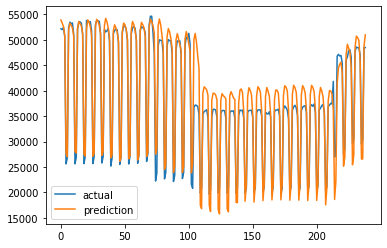

In [10]:
# plot actual vs prediction (All Test Data)
num_days = test_y.shape[0]
pyplot.plot(list(inv_y[:num_days]), label='actual')
pyplot.plot(inv_yhat[:num_days], label='prediction')
pyplot.legend()
pyplot.show()

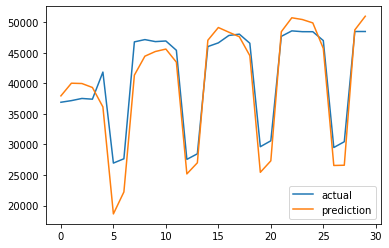

In [11]:
# plot actual vs prediction (Last 30 days)
num_days = 30
pyplot.plot(list(inv_y[-num_days:]), label='actual')
pyplot.plot(inv_yhat[-num_days:], label='prediction')
pyplot.legend()
pyplot.show()

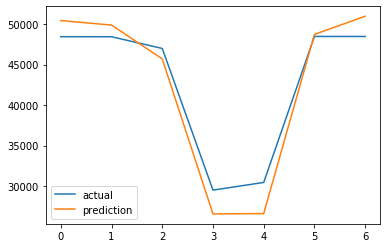

In [12]:
# plot actual vs prediction (Last 7 days)
num_days = 7
pyplot.plot(list(inv_y[-num_days:]), label='actual')
pyplot.plot(inv_yhat[-num_days:], label='prediction')
pyplot.legend()
pyplot.show()

In [13]:
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
prediction = model.predict(test_X[-1:])
print(prediction.shape)

new_pred_arr = []
for i in range(0, prediction.shape[1]):
    test_X = test_X.reshape((test_X.shape[0], n_input*n_features))
    inv_pred = concatenate(([[prediction[0][i]]], test_X[:prediction.shape[0], -(n_features-1):]), axis=1)
    inv_pred = inv_pred.reshape(1, inv_pred.shape[1])
    inv_pred = scaler.inverse_transform(inv_pred)
    inv_pred = inv_pred[:,0]
    new_pred_arr.append(inv_pred[0])
print(new_pred_arr)

(1, 7)
[50960.117, 52465.18, 52116.082, 51729.54, 29302.283, 26183.352, 50480.633]


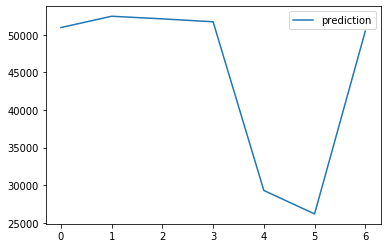

In [14]:
# plot prediction
pyplot.plot(new_pred_arr, label='prediction')
pyplot.legend()
pyplot.show()